# MRI Instance Segmentation Finetuning

Сегментация с помощью Finetuning-а модели resnet50 с использованием FastRCCN и MaskRCCN

In [ ]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
%%shell

pip install kaggle
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

## Датасет

[Датасет](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation?datasetId=181273) представлен на платформе kaggle. Оно представляет из себя снимки МРТ 110 пациентов. Примечателен датасет тем, что в нем есть исходы (смерти) пациентов.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download "mateuszbuda/lgg-mri-segmentation"

 99% 710M/714M [00:04<00:00, 177MB/s]
100% 714M/714M [00:04<00:00, 162MB/s]


In [ ]:
df = pd.read_csv(
    './kaggle_3m/data.csv',
    usecols=['Patient', 'gender', 'age_at_initial_pathologic', 'race', 'ethnicity', 'death01']
)

Прослеживается исход лечения у пациентов.

In [ ]:
df.head()

,Patient,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,2.0,39.0,3.0,NaN,0.0


Загрузим сами снимки. Нужно учесть, что там не всегда есть новообразование

In [ ]:
data_map = []
for sub_dir_path in glob("/content/kaggle_3m/*"):
    if os.path.isdir(sub_dir_path):
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])


In [ ]:
data = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
data.head()

,patient_id,path
0,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...
1,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...
2,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...
3,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...
4,TCGA_DU_6399_19830416,/content/kaggle_3m/TCGA_DU_6399_19830416/TCGA_...


In [ ]:
import re
import random

In [ ]:
data_imgs = data[~data['path'].str.contains("mask")]
data_masks = data[data['path'].str.contains("mask")]

# Data sorting
imgs = sorted(data_imgs["path"].values, key=lambda x : int(re.findall('_(\d+)\.tif', x)[0]))
masks = sorted(data_masks["path"].values, key=lambda x : int(re.findall('_(\d+)\_mask.tif', x)[0]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_64.tif 
Path to the Mask: /content/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_64_mask.tif


In [ ]:
import cv2

In [ ]:
brain_data = pd.DataFrame({"patient_id": data_imgs.patient_id.values,
                             "image_path": imgs,
                             "mask_path": masks
                            })

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0: 
        return 1
    else:
        return 0
    
brain_data['mask'] = brain_data['mask_path'].apply(lambda x: pos_neg_diagnosis(x))

In [ ]:
brain_data['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [ ]:
mask_imgs_idx = []
for i in range(len(brain_data)):
    if cv2.imread(brain_data.mask_path[i]).max() > 0:
        mask_imgs_idx.append(i)

In [ ]:
i = random.choice(mask_imgs_idx)

Пример новообразования

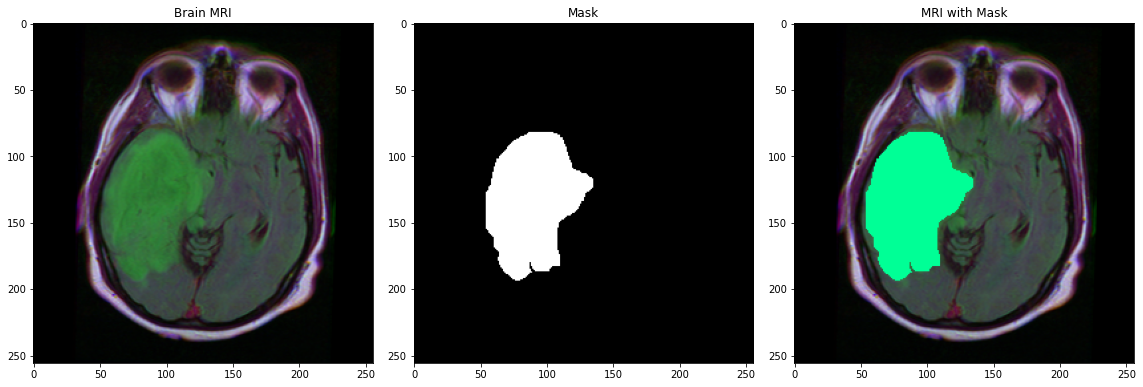

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 9))

img = cv2.imread(brain_data.image_path[i])
axes.flat[0].title.set_text("Brain MRI")
axes.flat[0].imshow(img)

mask = cv2.imread(brain_data.mask_path[i])[:, :, 2]
axes.flat[1].title.set_text("Mask")
axes.flat[1].imshow(mask, cmap='gray')

img[mask == 255] = (0, 255, 150)  # change pixel color at the position of mask
axes.flat[2].title.set_text("MRI with Mask")
axes.flat[2].imshow(img)

fig.tight_layout()

Реализуем датасет для дальнейшей обработки

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class MRIDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.transforms = transforms
        self.imgs = df['image_path'].tolist()
        self.masks = df['mask_path'].tolist()

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)[:, :, 0]
        mask[mask == 255] = 1

        pos = np.where(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]])

        labels = torch.ones((1, ), dtype=torch.int64)
        masks = torch.as_tensor(np.array([mask]), dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1, ), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = MRIDataset(brain_data.query('mask == 1'))

## Defining your model

Во вовремя работы мы будем использовать [Mask R-CNN](https://arxiv.org/abs/1703.06870), который базируется на[Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN это модель, который одновременно предсказывает позицию и класс объекта в фотографии. 

Mask R-CNN добавляет дополнительную ветку в Faster R-CNN, который также будет сегментировать маски для каждого объекта.


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

Подготовка скриптов для запуска

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Создание DataLoader-ов

In [ ]:
# use our dataset and defined transformations
dataset = MRIDataset(brain_data.query('mask == 1'), get_transform(train=True))
dataset_test = MRIDataset(brain_data.query('mask == 1'), get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-600])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-600:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Теперь инициализиуем саму модель и оптимизатор - SGD

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10


for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/387]  eta: 0:05:53  lr: 0.000018  loss: 3.8397 (3.8397)  loss_classifier: 0.3976 (0.3976)  loss_box_reg: 0.1015 (0.1015)  loss_mask: 3.2957 (3.2957)  loss_objectness: 0.0411 (0.0411)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 0.9124  data: 0.4145  max mem: 3960
Epoch: [0]  [ 10/387]  eta: 0:02:48  lr: 0.000147  loss: 2.3131 (2.3814)  loss_classifier: 0.3642 (0.3472)  loss_box_reg: 0.0688 (0.0691)  loss_mask: 1.8478 (1.8871)  loss_objectness: 0.0597 (0.0722)  loss_rpn_box_reg: 0.0048 (0.0059)  time: 0.4462  data: 0.0439  max mem: 4236
Epoch: [0]  [ 20/387]  eta: 0:02:36  lr: 0.000277  loss: 1.3024 (1.7573)  loss_classifier: 0.1989 (0.2520)  loss_box_reg: 0.0955 (0.0951)  loss_mask: 0.9225 (1.3500)  loss_objectness: 0.0391 (0.0542)  loss_rpn_box_reg: 0.0048 (0.0060)  time: 0.4032  data: 0.0071  max mem: 4236
Epoch: [0]  [ 30/387]  eta: 0:02:30  lr: 0.000406  loss: 0.9620 (1.4757)  loss_classifier: 0.1146 (0.2049)  loss_box_reg: 0.1025 (0.1010)  loss_mask: 0.7060 (1.1169) 

KeyboardInterrupt: ignored

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[ 64.7760,  48.0689, 139.7602, 142.3552]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9928], device='cuda:0')}]

Вывод модели представляет из себя позицию объекта на фотографии, его класс и маску, а также уверенность модели

Посмотрим на пример

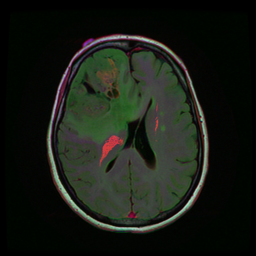

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Посмотрим на предсказанную маску

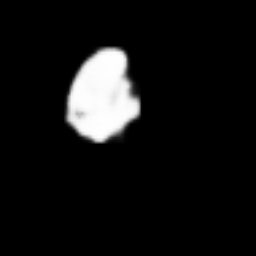

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())